<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Predicting_the_Beats-per-Minute_of_Songs/Predicting_The_Beats_%7C_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e9_path = kagglehub.competition_download('playground-series-s5e9')
gauravduttakiit_bpm_prediction_challenge_path = kagglehub.dataset_download('gauravduttakiit/bpm-prediction-challenge')

print('Data source import complete.')


# Introduction

This notebook presents a comprehensive solution for the **"Predicting the Beats-per-Minute of Songs"** Kaggle competition. We'll walk through every step of the machine learning pipeline, from data exploration to submission, with detailed explanations designed for beginners.

**What is BPM?**

Beats Per Minute (BPM) is a measure of tempo in music that indicates the number of beats in one minute. For example:

*   Slow ballads might have **60-80 BPM**
*   Pop songs often range from **100-130 BPM**
*   Dance and electronic music typically has **120-140 BPM**
*   Fast-paced genres like drum and bass can exceed **160 BPM**

**Competition Objective**

Our goal is to predict the BPM of songs based on various audio features. Success is measured by the **Root Mean Square Error (RMSE)** between our predictions and the actual BPM values.

**Important Note on This Dataset**

Recent analysis has shown that this competition's original dataset contained randomly assigned BPM values, but the synthetic data generation process likely added some signal. This means our goal is to create a robust model that can find whatever patterns exist in the competition data.

Let's begin!

In [ ]:
pip install --upgrade xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import kagglehub
gauravduttakiit_bpm_prediction_challenge_path = kagglehub.dataset_download('gauravduttakiit/bpm-prediction-challenge')

print('Data source import complete.')

Data source import complete.


# 1. Setup & data loading

In [ ]:

# ====================================================
# Setup & Imports
# ====================================================

# Standard Libraries
import os
import warnings
import random

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

# Gradient Boosting Models
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Settings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ====================================================
# Load Data
# ====================================================
try:
    train_ps = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
    test_ps = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
    sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e9/sample_submission.csv")

    print("Dataset Shapes:")
    print("Train:", train_ps.shape)
    print("Test:", test_ps.shape)
    print("Sample Submission:", sample_submission.shape)
    print()
except FileNotFoundError as e:
    print(f"⚠️ Error loading files: {e}")
    print("Please ensure train.csv, test.csv, and sample_submission.csv are available in the working directory.")


Dataset Shapes:
Train: (524164, 11)
Test: (174722, 10)
Sample Submission: (174722, 2)



# 2. Exploratory data analysis



## 2.1 Understanding the Features  

Before diving into the data, let’s review what each feature represents in the context of music 🎵.  

| Feature                   | Description |
|----------------------------|-------------|
| **RhythmScore**            | Rhythmic intensity and pattern clarity of the track |
| **AudioLoudness**          | Overall volume level (often measured in negative dB values) |
| **VocalContent**           | Presence and prominence of vocals |
| **AcousticQuality**        | Degree of acoustic (non-electronic) instrumentation |
| **InstrumentalScore**      | Degree to which the track is instrumental vs. vocal |
| **LivePerformanceLikelihood** | Likelihood the track sounds like a live recording |
| **MoodScore**              | Emotional character of the music |
| **TrackDurationMs**        | Length of the track (in milliseconds) |
| **Energy**                 | Perceived energy level of the track |
| **BeatsPerMinute (BPM)**   | 🎯 **Target variable** – the tempo of the track (beats per minute) |

🔎 **Why these features matter**:  
- Tracks with higher **RhythmScore** and **Energy** often correlate with higher BPM.  
- **VocalContent** and **InstrumentalScore** may influence tempo patterns depending on genre.  
- **TrackDurationMs** likely has little direct effect but could reveal genre-specific trends.  


## 2.2 Data information




In [ ]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""

    print(f"\n{'='*70}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*70}\n")

    # --- Head & Tail ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    print(f"--- {df_name} Tail ---\n")
    display(df.tail().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Info ---
    print(f"\n--- {df_name} Info ---\n")
    df.info()

    # --- Describe (numeric + categorical) ---
    print(f"\n--- {df_name} Describe (Numeric) ---\n")
    display(df.describe().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    print(f"\n--- {df_name} Describe (All Columns) ---\n")
    display(df.describe(include='all').transpose().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Missing Values ---
    print(f"\n--- {df_name} Missing Values ---\n")
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("✅ No missing values found.")
    else:
        missing_df = pd.DataFrame({
            'Missing Count': missing,
            'Missing %': (missing / len(df)) * 100
        }).query("`Missing Count` > 0")

        display(missing_df.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    print(f"\n{'='*70}\n")

# Apply to datasets
data_info(train_ps, "train_ps")
data_info(test_ps, "test_ps")



📊 Comprehensive Information for DataFrame: train_ps

--- train_ps Head ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.645000,0.826267,147.530200
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.517400,0.145400,136.159630
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.566700,0.624667,55.319890
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.465100,0.487467,147.912120
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.678900,0.947333,89.585110


--- train_ps Tail ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
524159,524159,0.796831,-13.405645,0.023500,0.504738,0.000001,0.191414,0.668079,135528.318900,0.004400,117.831180
524160,524160,0.975000,-12.132914,0.077379,0.069462,0.262320,0.124818,0.288946,240709.391800,0.447067,89.026810
524161,524161,0.542958,-1.357000,0.071390,0.168978,0.000001,0.313912,0.586868,344858.232100,0.718800,90.758850
524162,524162,0.637192,-7.411331,0.113086,0.000005,0.061946,0.287963,0.368891,322710.318700,0.944267,140.632350
524163,524163,0.776515,-5.484091,0.023500,0.271189,0.067338,0.339319,0.793487,313870.056600,0.223933,77.459600



--- train_ps Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB

--- train_ps Describe (Numeric) ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,262081.500000,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,151313.257586,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.000000,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,131040.750000,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,262081.500000,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,393122.250000,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,524163.000000,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000



--- train_ps Describe (All Columns) ---



,count,mean,std,min,25%,50%,75%,max
id,524164.000000,262081.500000,151313.257586,0.000000,131040.750000,262081.500000,393122.250000,524163.000000
RhythmScore,524164.000000,0.632843,0.156899,0.076900,0.515850,0.634686,0.739179,0.975000
AudioLoudness,524164.000000,-8.379014,4.616221,-27.509725,-11.551933,-8.252499,-4.912298,-1.357000
VocalContent,524164.000000,0.074443,0.049939,0.023500,0.023500,0.066425,0.107343,0.256401
AcousticQuality,524164.000000,0.262913,0.223120,0.000005,0.069413,0.242502,0.396957,0.995000
InstrumentalScore,524164.000000,0.117690,0.131845,0.000001,0.000001,0.074247,0.204065,0.869258
LivePerformanceLikelihood,524164.000000,0.178398,0.118186,0.024300,0.077637,0.166327,0.268946,0.599924
MoodScore,524164.000000,0.555843,0.225480,0.025600,0.403921,0.564817,0.716633,0.978000
TrackDurationMs,524164.000000,241903.692949,59326.601501,63973.000000,207099.876625,243684.058150,281851.658500,464723.228100
Energy,524164.000000,0.500923,0.289952,0.000067,0.254933,0.511800,0.746000,1.000000



--- train_ps Missing Values ---

✅ No missing values found.



📊 Comprehensive Information for DataFrame: test_ps

--- test_ps Head ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.549800,0.424867
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.664300,0.846000
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.012700,0.134067
3,524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.398900,0.316467
4,524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.538300,0.481067


--- test_ps Tail ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
174717,698881,0.332976,-9.654381,0.155402,0.143983,0.351255,0.307580,0.679634,255610.418900,0.427533
174718,698882,0.828106,-11.143536,0.121822,0.451146,0.096678,0.140123,0.274977,241204.940300,0.098333
174719,698883,0.569334,-4.253765,0.137968,0.246896,0.079425,0.102919,0.569331,127422.295500,0.193200
174720,698884,0.764595,-11.088025,0.055225,0.430128,0.006836,0.105584,0.653928,171586.583800,0.067467
174721,698885,0.823192,-16.435543,0.023500,0.346906,0.295836,0.167825,0.391377,334815.448600,0.436867



--- test_ps Info ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         174722 non-null  int64  
 1   RhythmScore                174722 non-null  float64
 2   AudioLoudness              174722 non-null  float64
 3   VocalContent               174722 non-null  float64
 4   AcousticQuality            174722 non-null  float64
 5   InstrumentalScore          174722 non-null  float64
 6   LivePerformanceLikelihood  174722 non-null  float64
 7   MoodScore                  174722 non-null  float64
 8   TrackDurationMs            174722 non-null  float64
 9   Energy                     174722 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 13.3 MB

--- test_ps Describe (Numeric) ---



,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
count,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000
mean,611524.500000,0.632591,-8.377495,0.074475,0.262903,0.117407,0.178317,0.555861,241753.736419,0.500545
std,50438.041204,0.157229,4.622288,0.050024,0.222899,0.131628,0.118165,0.226218,59103.896616,0.290550
min,524164.000000,0.140859,-27.442731,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067
25%,567844.250000,0.514918,-11.550095,0.023500,0.069448,0.000001,0.077821,0.403788,207518.151300,0.253817
50%,611524.500000,0.634556,-8.253186,0.066432,0.242412,0.073968,0.165956,0.566015,243584.585400,0.511867
75%,655204.750000,0.739179,-4.903740,0.107302,0.396870,0.202977,0.268133,0.716694,281737.445300,0.746133
max,698885.000000,0.975000,-1.357000,0.258857,0.995000,0.680914,0.599544,0.978000,449288.808400,0.999867



--- test_ps Describe (All Columns) ---



,count,mean,std,min,25%,50%,75%,max
id,174722.000000,611524.500000,50438.041204,524164.000000,567844.250000,611524.500000,655204.750000,698885.000000
RhythmScore,174722.000000,0.632591,0.157229,0.140859,0.514918,0.634556,0.739179,0.975000
AudioLoudness,174722.000000,-8.377495,4.622288,-27.442731,-11.550095,-8.253186,-4.903740,-1.357000
VocalContent,174722.000000,0.074475,0.050024,0.023500,0.023500,0.066432,0.107302,0.258857
AcousticQuality,174722.000000,0.262903,0.222899,0.000005,0.069448,0.242412,0.396870,0.995000
InstrumentalScore,174722.000000,0.117407,0.131628,0.000001,0.000001,0.073968,0.202977,0.680914
LivePerformanceLikelihood,174722.000000,0.178317,0.118165,0.024300,0.077821,0.165956,0.268133,0.599544
MoodScore,174722.000000,0.555861,0.226218,0.025600,0.403788,0.566015,0.716694,0.978000
TrackDurationMs,174722.000000,241753.736419,59103.896616,63973.000000,207518.151300,243584.585400,281737.445300,449288.808400
Energy,174722.000000,0.500545,0.290550,0.000067,0.253817,0.511867,0.746133,0.999867



--- test_ps Missing Values ---

✅ No missing values found.




## 2.3 Numerical/Categorical Feature Identification




In [ ]:
# Define excluded features
excluded_features = ['id', 'BeatsPerMinute']

# Separate numerical and categorical features
numerical_features = [
    col for col in train_ps.select_dtypes(include=np.number).columns
    if col not in excluded_features
]

categorical_features = [
    col for col in train_ps.select_dtypes(exclude=np.number).columns
    if col not in excluded_features
]

# Print results
print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")


Numerical Features (9): ['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'TrackDurationMs', 'Energy']
Categorical Features (0): []


## 2.4 Correlation Heatmap

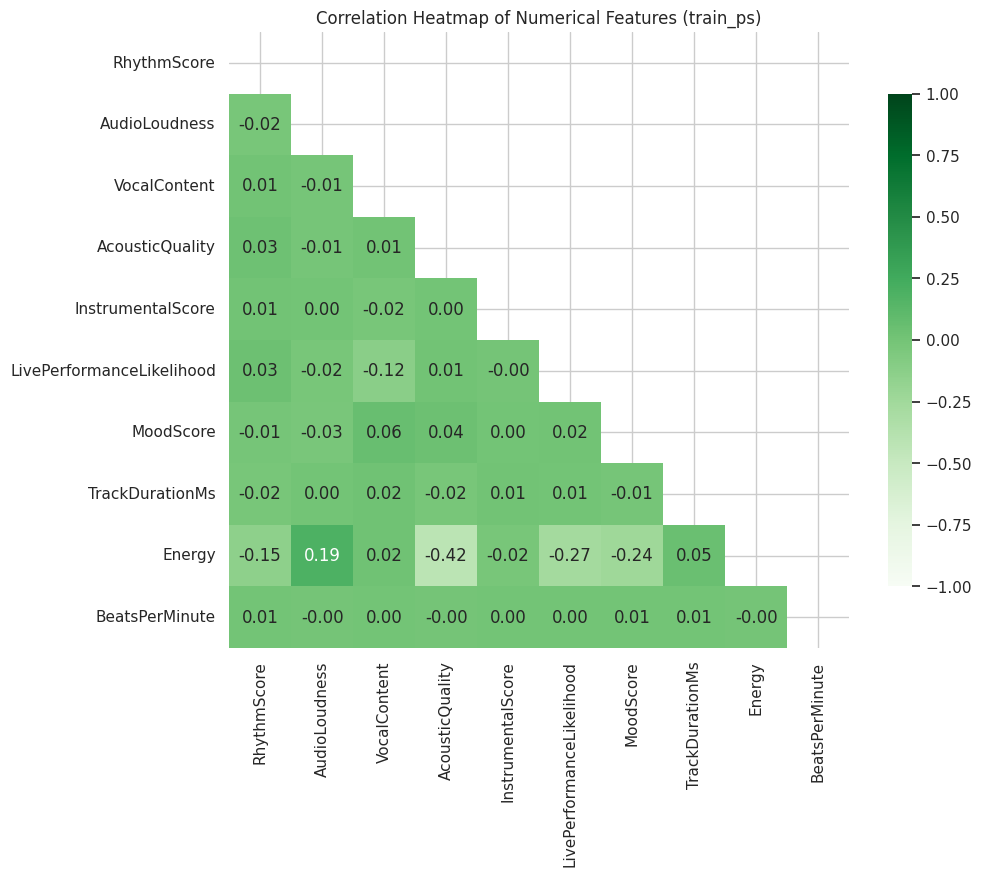

In [ ]:
def plot_correlation_heatmap(df, numerical_cols, df_name, annot=True):
    """
    Generates and displays a correlation heatmap for specified numerical columns,
    showing only the lower triangle.
    """
    corr = df[numerical_cols].corr()

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr,
        mask=mask,
        annot=annot,
        cmap='Greens',
        fmt=".2f",
        vmin=-1, vmax=1,
        cbar_kws={"shrink": .8}
    )
    plt.title(f'Correlation Heatmap of Numerical Features ({df_name})')
    plt.show()

# Add target for correlation analysis
numerical_features_with_target = numerical_features + ['BeatsPerMinute']

plot_correlation_heatmap(train_ps, numerical_features_with_target, "train_ps")


## 2.5 Numerical Feature Distributions (Train vs Test)

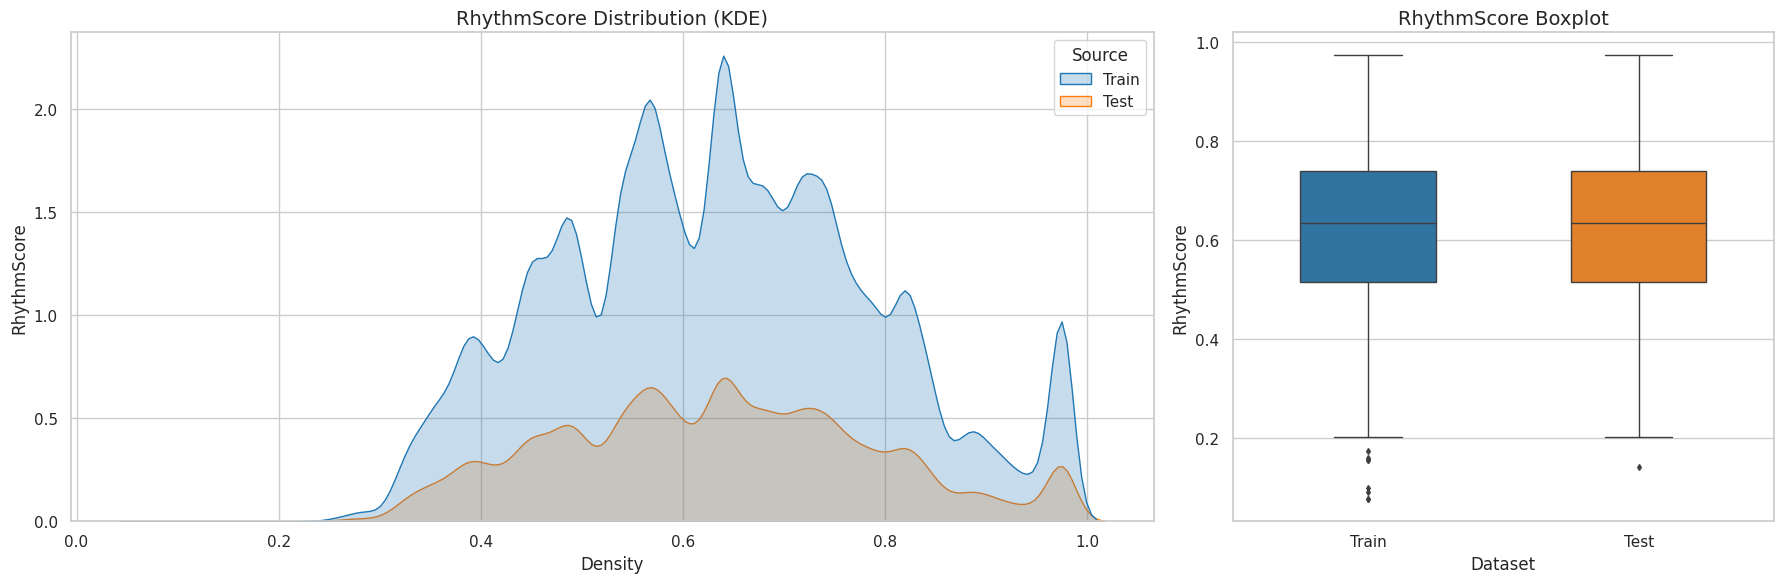

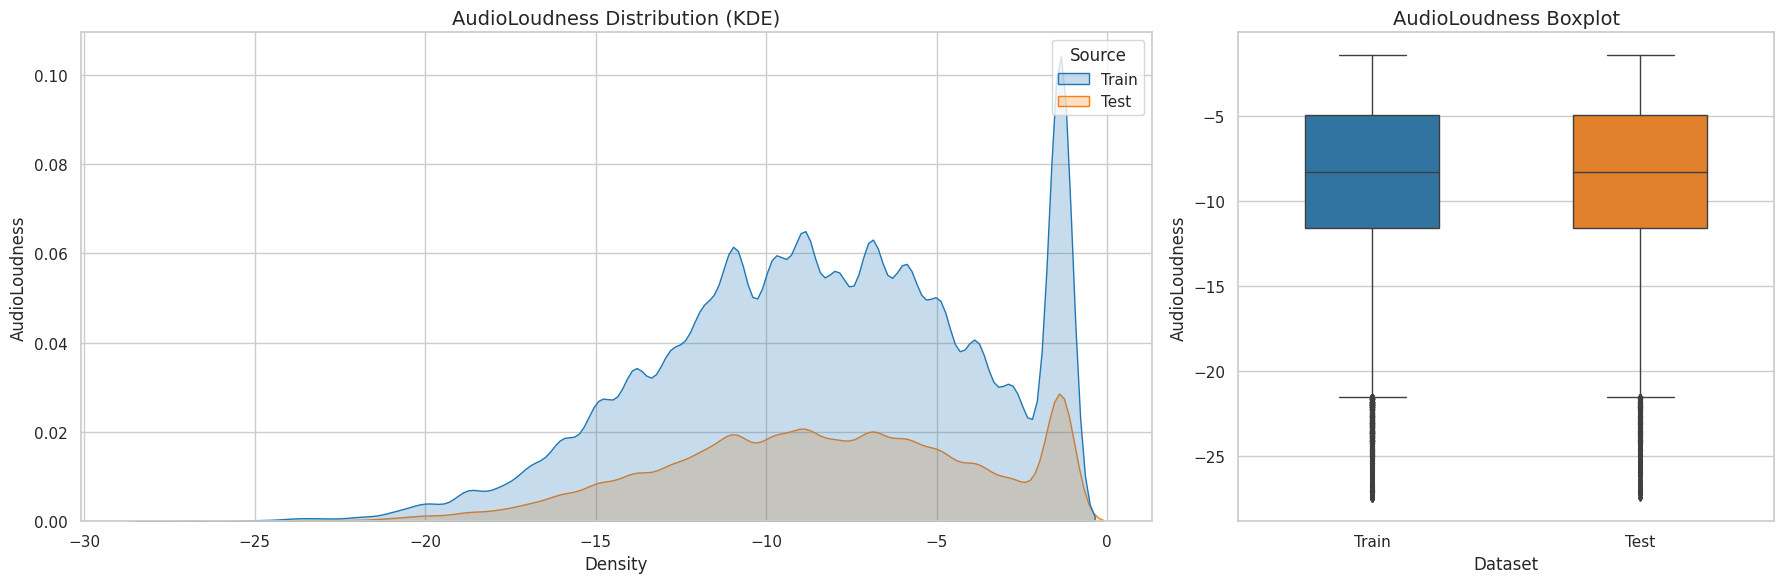

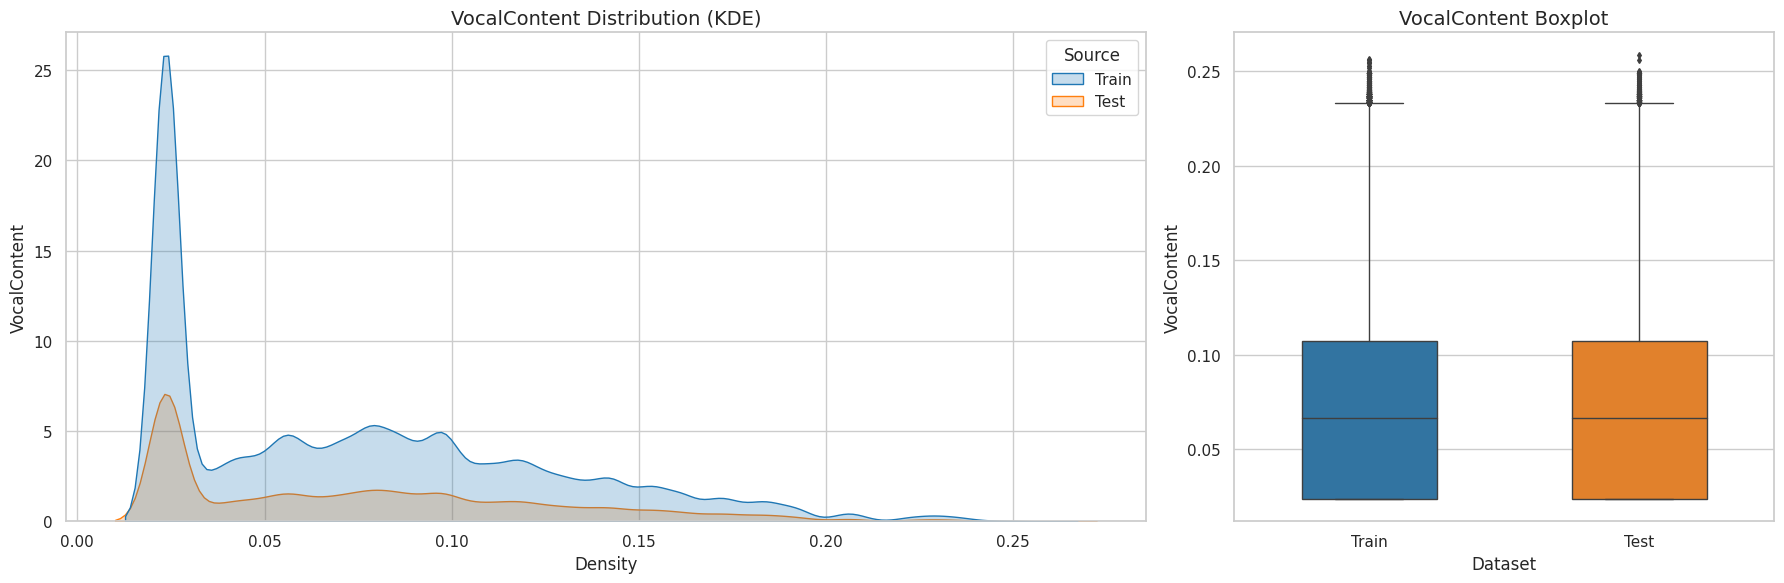

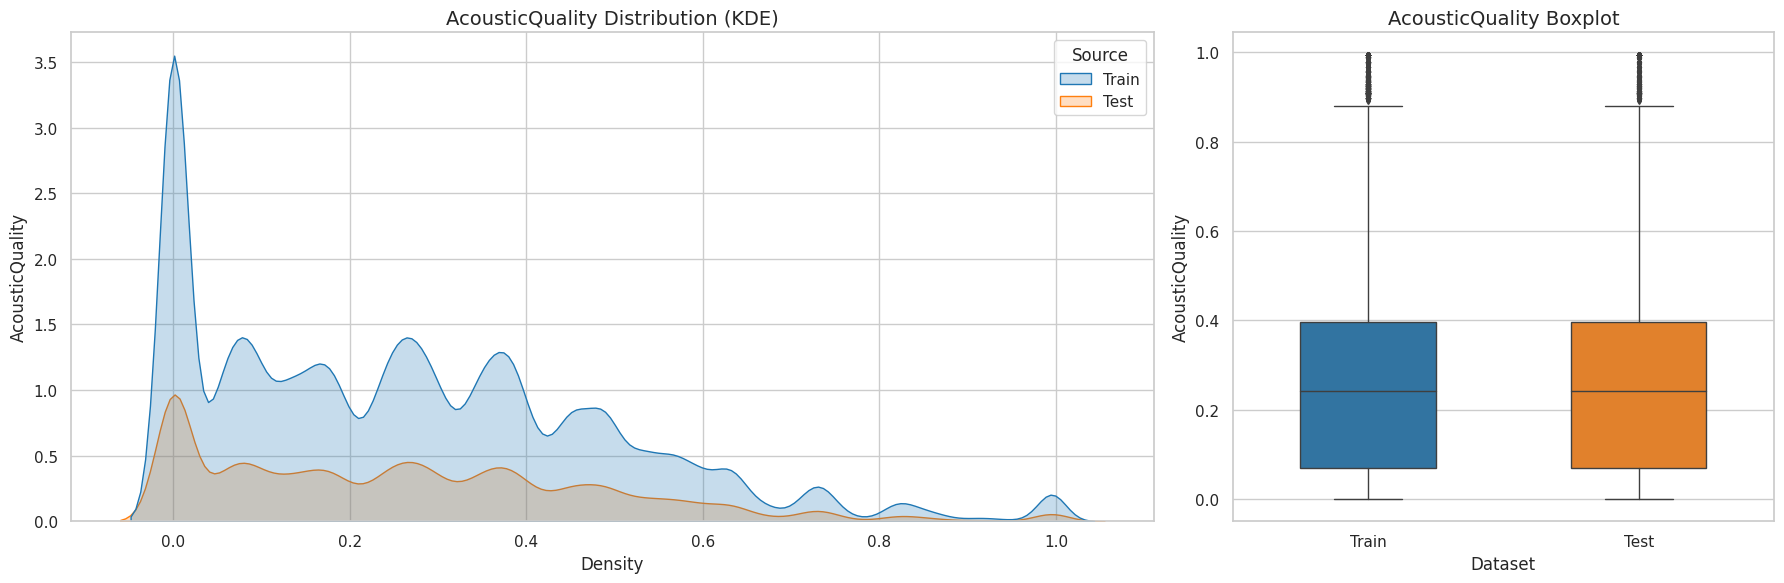

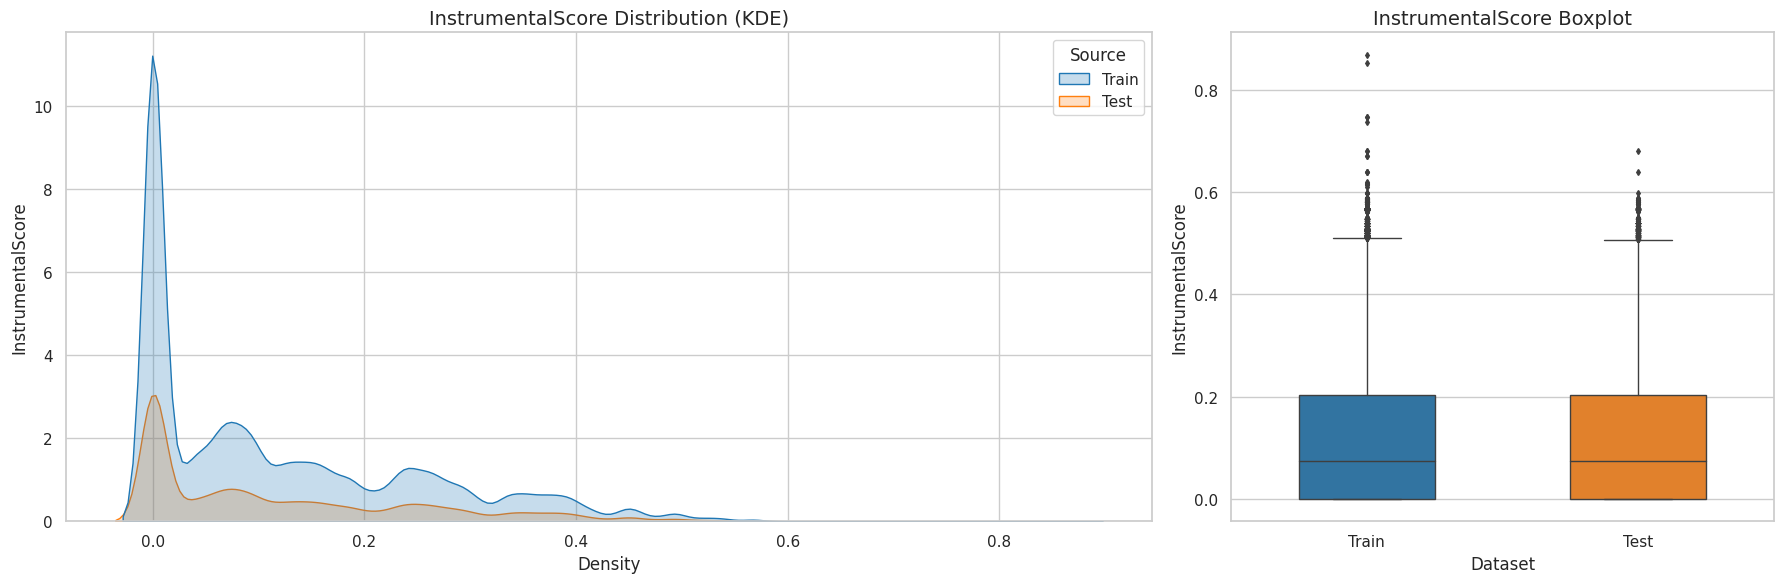

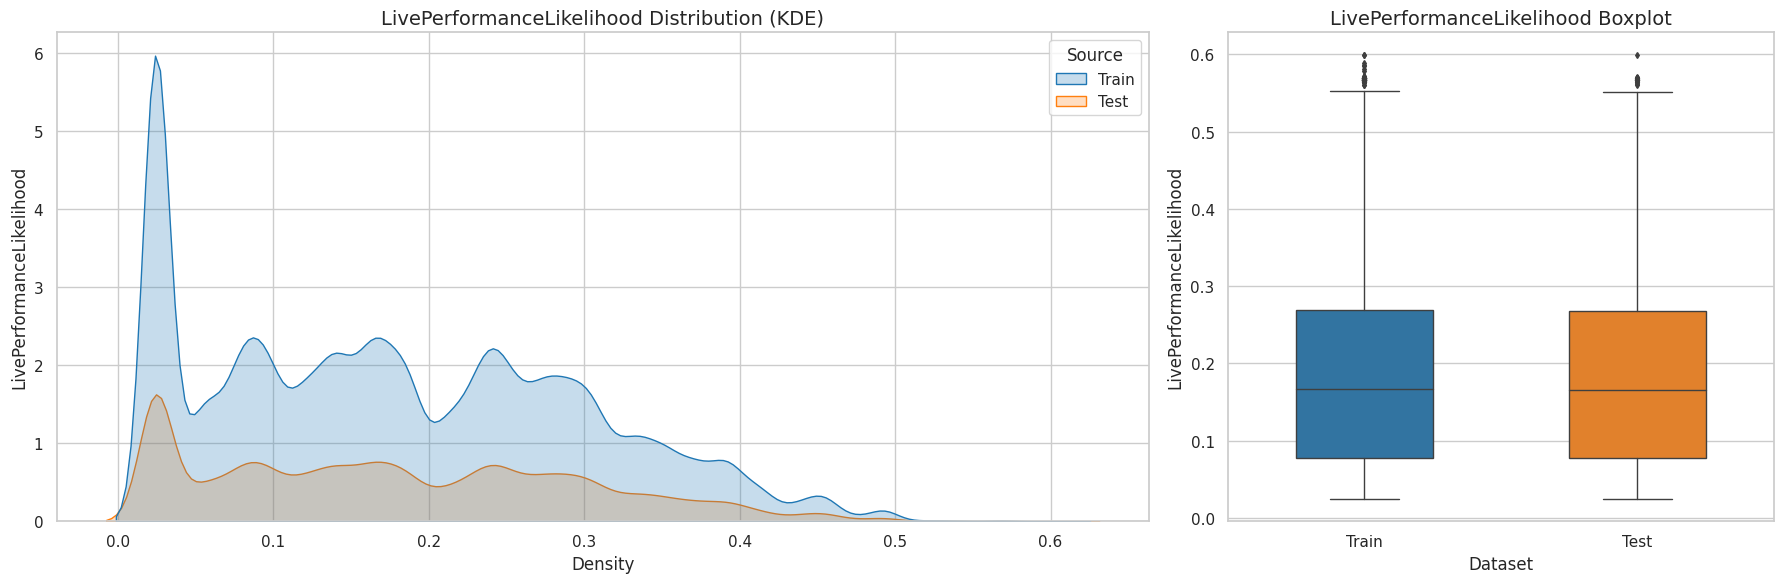

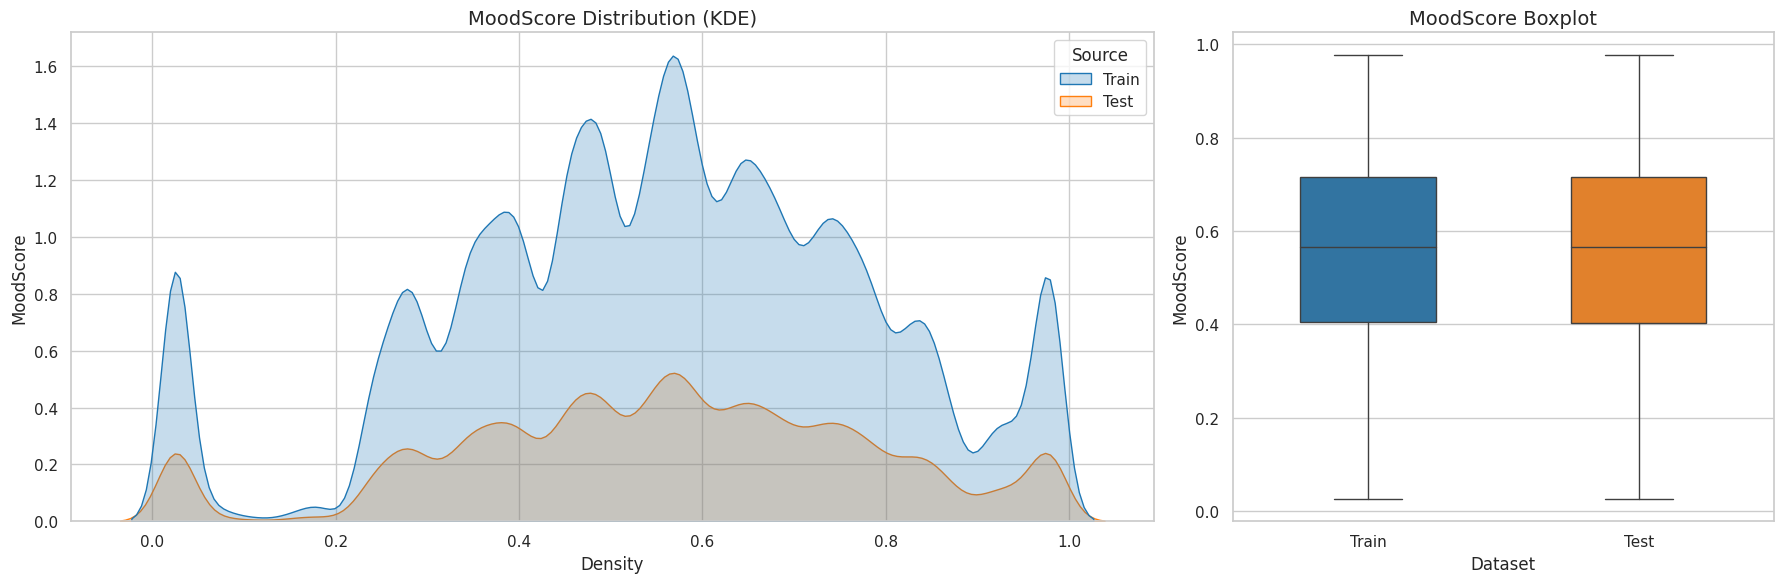

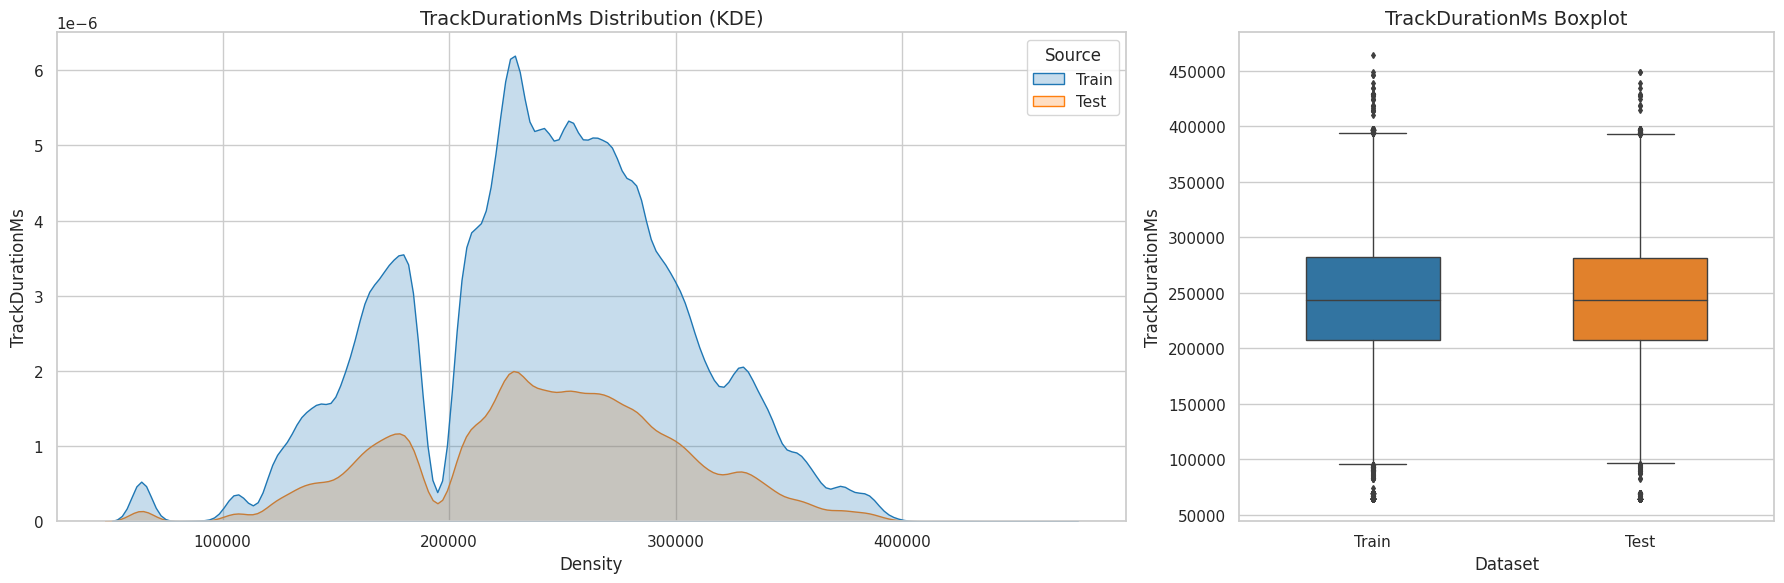

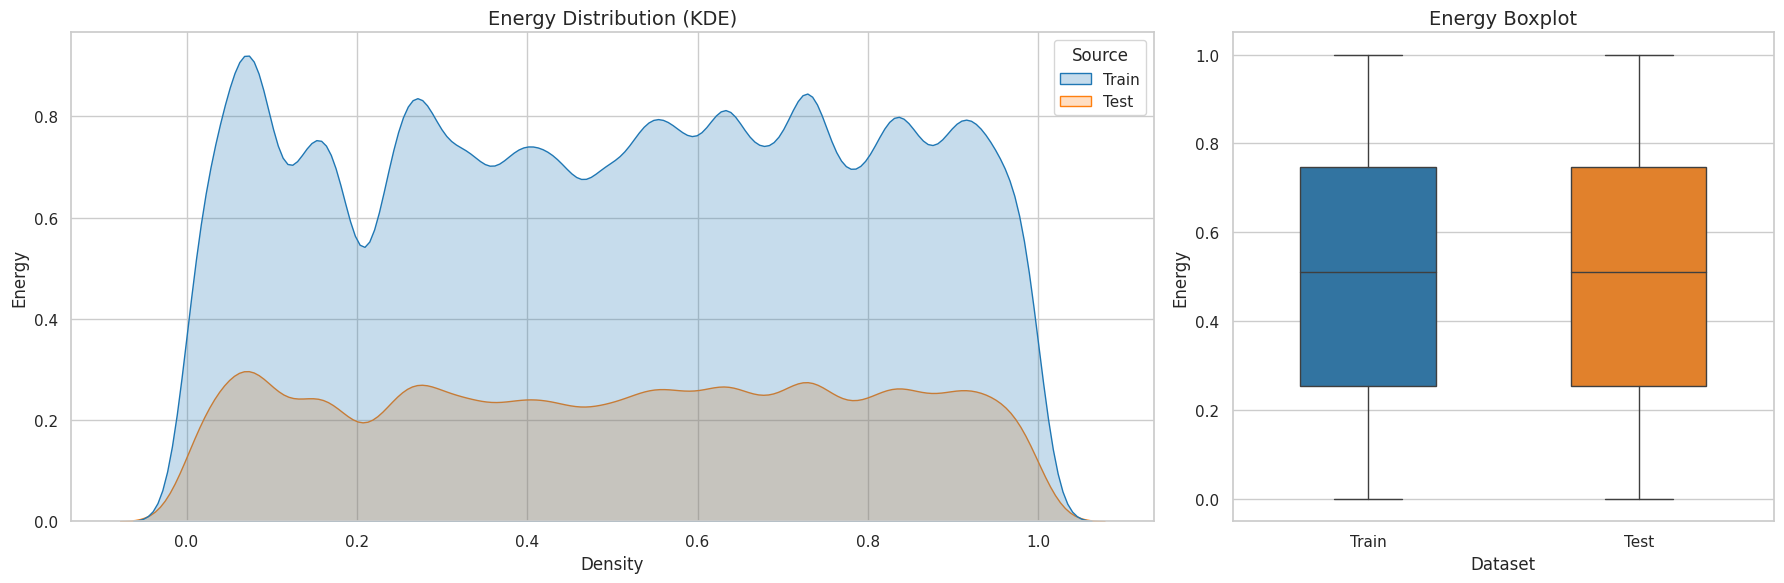

In [ ]:
def plot_numerical_distributions(train_df, test_df, numerical_cols):
    """
    Generates KDE and box plots for numerical features, comparing train vs test distributions.
    """
    sns.set_style("whitegrid")
    sns.set_context("notebook")

    # Combine train and test for plotting
    combined_df = pd.concat([
        train_df[numerical_cols].assign(Source='Train'),
        test_df[numerical_cols].assign(Source='Test')
    ], axis=0, ignore_index=True)

    palette = ['#1f77b4', '#ff7f0e']  # Distinct colors for Train/Test

    for col in numerical_cols:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [2, 1]})

        # KDE Plot
        sns.kdeplot(
            data=combined_df, x=col, hue='Source', ax=axes[0], fill=True, palette=palette
        )
        axes[0].set_title(f'{col} Distribution (KDE)', fontsize=14)
        axes[0].set_xlabel('Density')
        axes[0].set_ylabel(col)

        # Box Plot
        sns.boxplot(
            data=combined_df, y=col, x='Source', ax=axes[1],
            orient='v', width=0.5, linewidth=1, fliersize=3, palette=palette
        )
        axes[1].set_title(f'{col} Boxplot', fontsize=14)
        axes[1].set_xlabel('Dataset')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

# Call the function for numerical features
plot_numerical_distributions(train_ps, test_ps, numerical_features)


## 2.6 Categorical Feature Distributions (Train vs Test)




In [ ]:
def plot_categorical_distributions(train_df, test_df, categorical_cols):
    """
    Generates count plots for each categorical feature, comparing train and test distributions.
    Uses side-by-side bars for clear comparison.
    """
    if len(categorical_cols) == 0:
        print("No categorical features to plot.")
        return

    palette = ['#1f77b4', '#ff7f0e']  # Train / Test colors

    for col in categorical_cols:
        plt.figure(figsize=(10, 6))

        # Combine train and test with a source column
        combined = pd.concat([
            train_df[[col]].assign(Source='Train'),
            test_df[[col]].assign(Source='Test')
        ], axis=0, ignore_index=True)

        sns.countplot(x=col, hue='Source', data=combined, palette=palette)

        plt.title(f'Distribution of {col} (Train vs Test)', fontsize=14)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Dataset')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Call the function
plot_categorical_distributions(train_ps, test_ps, categorical_features)


No categorical features to plot.


## 2.7 Target Variable Distribution



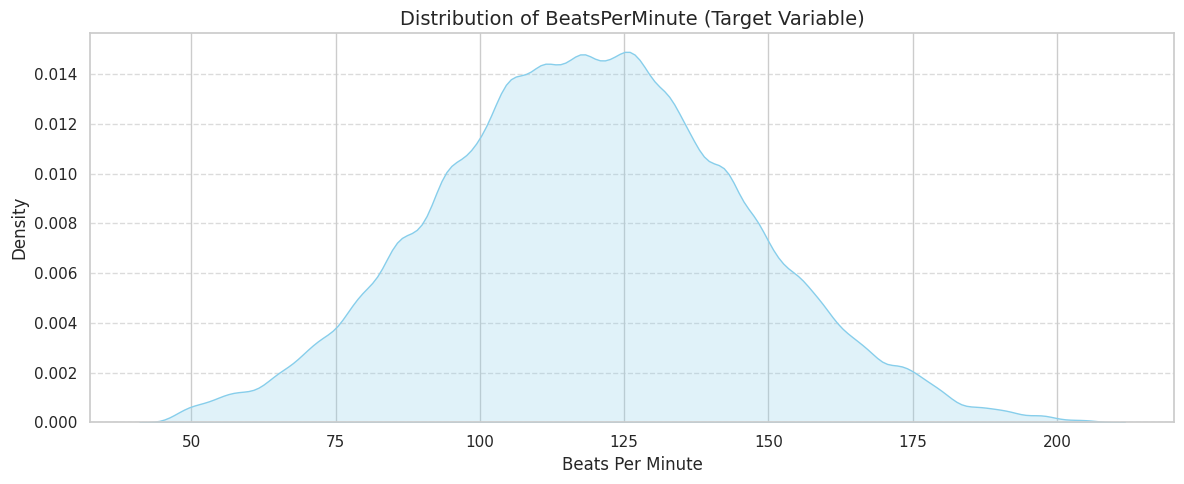

In [ ]:


plt.figure(figsize=(12, 5))
sns.kdeplot(data=train_ps, x='BeatsPerMinute', palette='viridis', fill=True, color='skyblue')
plt.title("Distribution of BeatsPerMinute (Target Variable)", fontsize=14)
plt.xlabel("Beats Per Minute")
plt.ylabel("Density")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


-----

# 3. Preprocessing & feature engineering




### 3.1 Missing Value Check

In [ ]:
# Check total missing values
train_missing = train_ps.isnull().sum().sum()
test_missing = test_ps.isnull().sum().sum()

print(f"✅ Total missing values in train_ps: {train_missing}")
print(f"✅ Total missing values in test_ps: {test_missing}")


✅ Total missing values in train_ps: 0
✅ Total missing values in test_ps: 0


### 3.2 Memory Reduction

In [ ]:
def reduce_memory_usage(df):
    """
    Reduce memory usage of a DataFrame by downcasting numerical columns and converting object columns to category.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_mem:.2f} MB")

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type).startswith('int'):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:  # float
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage after optimization is: {end_mem:.2f} MB")
    print(f"Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%")

    return df

# Apply memory reduction
train_ps = reduce_memory_usage(train_ps)
test_ps = reduce_memory_usage(test_ps)


Memory usage of dataframe is 43.99 MB
Memory usage after optimization is: 13.00 MB
Decreased by 70.5%
Memory usage of dataframe is 13.33 MB
Memory usage after optimization is: 4.00 MB
Decreased by 70.0%


### 3.3 Transformations (Log, Relative Loudness)

In [ ]:
import numpy as np
import pandas as pd

# Reload original data
try:
    train_ps_original = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
    test_ps_original = pd.read_csv("/kaggle/input/playground-series-s5e9/test.csv")
    print("✅ Original data reloaded for preprocessing.")
except FileNotFoundError as e:
    print(f"Error reloading original files: {e}")
    exit()

# Store lengths for later splitting
train_len = len(train_ps_original)
test_len = len(test_ps_original)
print(f"Train rows: {train_len}, Test rows: {test_len}")

# Combine train and test (excluding target) for consistent preprocessing
combined_ps = pd.concat(
    [train_ps_original.drop('BeatsPerMinute', axis=1), test_ps_original],
    ignore_index=True
)

# Handle missing values (drop or optionally impute)
if combined_ps.isnull().sum().sum() > 0:
    print("⚠️ Missing values detected. Dropping rows with NaNs.")
combined_ps_cleaned = combined_ps.dropna()

# Transformations

# 1. Log-transform TrackDurationMs to reduce skewness
if 'TrackDurationMs' in combined_ps_cleaned.columns:
    combined_ps_cleaned['TrackDurationMs'] = np.log1p(combined_ps_cleaned['TrackDurationMs'])
    print("✅ Applied log1p transformation to TrackDurationMs.")
else:
    print("⚠️ TrackDurationMs not found for log transformation.")

# 2. Relative Loudness: convert AudioLoudness (negative dB) to positive relative scale
if 'AudioLoudness' in combined_ps_cleaned.columns:
    max_loudness = combined_ps_cleaned['AudioLoudness'].max()
    combined_ps_cleaned['RelativeLoudness'] = max_loudness - combined_ps_cleaned['AudioLoudness']
    combined_ps_cleaned.drop('AudioLoudness', axis=1, inplace=True)
    print("✅ Created RelativeLoudness and dropped AudioLoudness.")
else:
    print("⚠️ AudioLoudness not found for RelativeLoudness transformation.")

# Split back into train and test
train_processed = combined_ps_cleaned.iloc[:train_len, :].copy()
test_processed = combined_ps_cleaned.iloc[train_len:, :].copy()

print(f"Processed train shape: {train_processed.shape}")
print(f"Processed test shape: {test_processed.shape}")


✅ Original data reloaded for preprocessing.
Train rows: 524164, Test rows: 174722
✅ Applied log1p transformation to TrackDurationMs.
✅ Created RelativeLoudness and dropped AudioLoudness.
Processed train shape: (524164, 10)
Processed test shape: (174722, 10)


### 3.4 Feature Creation (Binning, Interactions, Domain Features)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Small epsilon to avoid division by zero
epsilon = 1e-6

# -----------------------------
# 1️⃣ Binning / Discretization
# -----------------------------
features_to_bin = ['RelativeLoudness', 'MoodScore']
for col in features_to_bin:
    if col in combined_ps_cleaned.columns:
        combined_ps_cleaned[f'{col}_Quartile'] = pd.qcut(
            combined_ps_cleaned[col], q=4, labels=False, duplicates='drop'
        )
        print(f"✅ Binned {col} into quartiles.")
    else:
        print(f"⚠️ Column {col} not found for binning.")

# TrackDurationMs bucketed into short/medium/long
if 'TrackDurationMs' in combined_ps_cleaned.columns:
    combined_ps_cleaned['TrackDurationBucket'] = pd.qcut(
        combined_ps_cleaned['TrackDurationMs'],
        q=3,
        labels=['short', 'medium', 'long'],
        duplicates='drop'
    )

    # Ordinal encoding for bucket
    categories_order = [['short', 'medium', 'long']]
    ordinal_encoder = OrdinalEncoder(
        categories=categories_order,
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )
    combined_ps_cleaned['TrackDurationBucket'] = ordinal_encoder.fit_transform(
        combined_ps_cleaned[['TrackDurationBucket']]
    )
    print("✅ Created and encoded TrackDurationBucket.")
else:
    print("⚠️ TrackDurationMs not found for TrackDurationBucket creation.")

# -----------------------------
# 2️⃣ Interaction Features
# -----------------------------
interaction_cols_required = [
    'Energy', 'RhythmScore', 'MoodScore', 'VocalContent', 'InstrumentalScore', 'AcousticQuality'
]
if all(col in combined_ps_cleaned.columns for col in interaction_cols_required):
    combined_ps_cleaned['Energy_x_RhythmScore'] = combined_ps_cleaned['Energy'] * combined_ps_cleaned['RhythmScore']
    combined_ps_cleaned['MoodScore_x_RhythmScore'] = combined_ps_cleaned['MoodScore'] * combined_ps_cleaned['RhythmScore']
    combined_ps_cleaned['Vocals_vs_Instrument'] = combined_ps_cleaned['VocalContent'] / (
        combined_ps_cleaned['InstrumentalScore'] + epsilon
    )
    combined_ps_cleaned['Energy_minus_AcousticQuality'] = combined_ps_cleaned['Energy'] - combined_ps_cleaned['AcousticQuality']
    print("✅ Created interaction features.")
else:
    print("⚠️ Necessary columns not found for interaction features.")

# -----------------------------
# 3️⃣ Domain-Specific Features
# -----------------------------
domain_cols_required = ['RelativeLoudness', 'TrackDurationMs', 'LivePerformanceLikelihood', 'Energy']
if all(col in combined_ps_cleaned.columns for col in domain_cols_required):
    combined_ps_cleaned['NormalizedLoudness'] = combined_ps_cleaned['RelativeLoudness'] / (
        combined_ps_cleaned['TrackDurationMs'] + epsilon
    )
    combined_ps_cleaned['LiveEnergy'] = combined_ps_cleaned['LivePerformanceLikelihood'] * combined_ps_cleaned['Energy']
    print("✅ Created domain-specific features.")
else:
    print("⚠️ Necessary columns not found for domain feature creation.")

# -----------------------------
# List of all new features
# -----------------------------
new_features = [
    'RelativeLoudness_Quartile', 'MoodScore_Quartile', 'TrackDurationBucket',
    'Energy_x_RhythmScore', 'MoodScore_x_RhythmScore',
    'Vocals_vs_Instrument', 'Energy_minus_AcousticQuality',
    'NormalizedLoudness', 'LiveEnergy'
]

print(f"📝 Total new features created: {len(new_features)}")
print(new_features)


✅ Binned RelativeLoudness into quartiles.
✅ Binned MoodScore into quartiles.
✅ Created and encoded TrackDurationBucket.
✅ Created interaction features.
✅ Created domain-specific features.
📝 Total new features created: 9
['RelativeLoudness_Quartile', 'MoodScore_Quartile', 'TrackDurationBucket', 'Energy_x_RhythmScore', 'MoodScore_x_RhythmScore', 'Vocals_vs_Instrument', 'Energy_minus_AcousticQuality', 'NormalizedLoudness', 'LiveEnergy']


### 3.5 Scaling (StandardScaler)

In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# -----------------------------
# 1️⃣ Identify numeric features for scaling
# -----------------------------
numerical_features_final = combined_ps_cleaned.select_dtypes(include=np.number).columns.tolist()
numerical_features_final = [col for col in numerical_features_final if col not in ['id', 'BeatsPerMinute']]
print(f"\nNumeric features to scale: {numerical_features_final}")

# -----------------------------
# 2️⃣ Split combined dataset into train and test
# -----------------------------
train_ps_processed = combined_ps_cleaned.iloc[:train_len].reset_index(drop=True).copy()
test_ps_processed = combined_ps_cleaned.iloc[train_len:].reset_index(drop=True).copy()

# -----------------------------
# 3️⃣ Apply StandardScaler
# -----------------------------
scaler = StandardScaler()
train_scaled_values = scaler.fit_transform(train_ps_processed[numerical_features_final])
test_scaled_values = scaler.transform(test_ps_processed[numerical_features_final])

# Convert scaled arrays back to DataFrames
train_scaled_df = pd.DataFrame(train_scaled_values, columns=numerical_features_final, index=train_ps_processed.index)
test_scaled_df = pd.DataFrame(test_scaled_values, columns=numerical_features_final, index=test_ps_processed.index)

# -----------------------------
# 4️⃣ Preserve IDs
# -----------------------------
train_scaled_df['id'] = train_ps_processed['id'].values
test_scaled_df['id'] = test_ps_processed['id'].values

# -----------------------------
# 5️⃣ Merge target variable (BeatsPerMinute) for train
# -----------------------------
# Using the original train CSV to preserve target
train_original = pd.read_csv("/kaggle/input/playground-series-s5e9/train.csv")
train_scaled_df = pd.merge(train_scaled_df, train_original[['id', 'BeatsPerMinute']], on='id', how='left')

# -----------------------------
# 6️⃣ Prepare final feature and target sets
# -----------------------------
final_features_list = [col for col in train_scaled_df.columns if col not in ['id', 'BeatsPerMinute']]

X_train_processed = train_scaled_df[final_features_list].copy()
y_train_processed = train_scaled_df['BeatsPerMinute'].copy()
X_test_processed = test_scaled_df[final_features_list].copy()

# -----------------------------
# 7️⃣ Check shapes and sample data
# -----------------------------
print("\nTrain features shape:", X_train_processed.shape)
print("Train target shape:", y_train_processed.shape)
print("Test features shape:", X_test_processed.shape)

print("\nHead of X_train_processed:")
display(X_train_processed.head())

print("\nHead of X_test_processed:")
display(X_test_processed.head())



Numeric features to scale: ['RhythmScore', 'VocalContent', 'AcousticQuality', 'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 'TrackDurationMs', 'Energy', 'RelativeLoudness', 'RelativeLoudness_Quartile', 'MoodScore_Quartile', 'TrackDurationBucket', 'Energy_x_RhythmScore', 'MoodScore_x_RhythmScore', 'Vocals_vs_Instrument', 'Energy_minus_AcousticQuality', 'NormalizedLoudness', 'LiveEnergy']

Train features shape: (524164, 18)
Train target shape: (524164,)
Test features shape: (174722, 18)

Head of X_train_processed:


,RhythmScore,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RelativeLoudness,RelativeLoudness_Quartile,MoodScore_Quartile,TrackDurationBucket,Energy_x_RhythmScore,MoodScore_x_RhythmScore,Vocals_vs_Instrument,Energy_minus_AcousticQuality,NormalizedLoudness,LiveEnergy
0,-0.186320,-1.020114,-1.178322,-0.892636,-1.074691,-0.647405,0.788668,1.122062,-0.160753,-0.447378,-0.446988,1.223843,0.964538,-0.614077,-0.036159,1.356835,-0.184983,-0.486660
1,0.042116,-0.058541,0.815779,1.757555,-0.066641,0.422064,-1.265523,-1.226143,1.708885,1.341690,0.447589,-1.224759,-1.112388,0.382710,-0.547273,-1.239864,1.799793,-0.714190
2,-0.754022,0.726325,-0.399847,2.549397,-1.259230,-0.585321,-1.053110,0.426774,1.640859,1.341690,-0.446988,-1.224759,0.056880,-0.787033,-0.547272,0.491200,1.714030,-0.795585
3,0.647674,-0.430095,-1.170947,0.318762,-0.778712,-1.228925,-0.126821,-0.046407,-1.521162,-1.341911,-1.341566,-0.000458,0.244277,-0.865923,-0.547268,0.571578,-1.519856,-0.491266
4,-0.636554,-1.020114,-0.870498,-0.892636,1.294126,-0.346257,-0.317430,1.539602,1.013259,1.341690,-0.446988,-1.224759,0.996049,-0.571367,-0.036159,1.477664,1.029106,3.009682



Head of X_test_processed:


,RhythmScore,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RelativeLoudness,RelativeLoudness_Quartile,MoodScore_Quartile,TrackDurationBucket,Energy_x_RhythmScore,MoodScore_x_RhythmScore,Vocals_vs_Instrument,Energy_minus_AcousticQuality,NormalizedLoudness,LiveEnergy
0,-1.420214,-1.020114,-0.134470,-0.796403,0.788482,0.481099,0.936828,-0.262305,1.823128,1.341690,0.447589,1.223843,-0.696638,-0.466639,-0.547199,-0.106224,1.750984,0.452737
1,-1.082049,1.349161,-0.919627,1.063766,-0.683456,1.213896,-0.184412,1.190119,-1.521162,-1.341911,1.342167,-1.224759,0.416934,0.192973,-0.547258,1.269217,-1.519856,0.030270
2,0.342422,1.870453,0.111648,0.707083,1.248127,-1.112582,1.537062,-1.265230,-1.085323,-1.341911,-1.341566,1.223843,-1.117150,-0.838416,-0.547247,-0.903632,-1.099135,-0.470747
3,1.612179,0.881993,-1.178322,1.966072,-0.371990,-0.302036,0.545786,-0.636160,-0.602434,-0.447378,-0.446988,1.223843,-0.153444,0.475650,-0.547268,0.180952,-0.613523,-0.485553
4,0.028986,1.034398,1.237720,-0.369680,-1.303869,0.157018,0.623769,-0.068480,-0.283967,-0.447378,0.447589,1.223843,-0.018808,0.149974,-0.547200,-0.682778,-0.301458,-0.882982


In [ ]:
import pandas as pd

print("--- Comparison of Features Before and After Feature Creation ---")

# -----------------------------
# Original numerical features (before feature engineering)
# -----------------------------
features_before = [col for col in numerical_features if col not in ['id', 'BeatsPerMinute']]
print("\nFeatures Before Feature Creation (Original Numerical Features):")
display(features_before)

# -----------------------------
# Final processed features (after feature engineering and scaling)
# -----------------------------
features_after = X_train_processed.columns.tolist()
print("\nFeatures After Feature Creation (Final Processed Features):")
display(features_after)

# -----------------------------
# Identify added or transformed features
# -----------------------------
added_or_transformed_features = [feature for feature in features_after if feature not in features_before]
print("\nFeatures Added or Transformed During Feature Creation:")
display(added_or_transformed_features)

# -----------------------------
# Identify original features that were kept
# -----------------------------
kept_original_features = [feature for feature in features_after if feature in features_before]
print("\nOriginal Numerical Features Kept in the Final Set:")
display(kept_original_features)

# -----------------------------
# Explanation of added/engineered features
# -----------------------------
print("\nExplanation of Added/Transformed Features:")
print("- RelativeLoudness: Derived from AudioLoudness.")
print("- TrackDurationMs: Log-transformed to reduce skewness.")
print("- MoodScore_Quartile, RelativeLoudness_Quartile, TrackDurationBucket: Binned/categorized features.")
print("- Energy_x_RhythmScore, MoodScore_x_RhythmScore, Vocals_vs_Instrument, Energy_minus_AcousticQuality: Interaction features.")
print("- NormalizedLoudness, LiveEnergy: Domain-specific engineered features.")
print("\n✅ This summary shows the impact of feature engineering and what the models will learn from.")


--- Comparison of Features Before and After Feature Creation ---

Features Before Feature Creation (Original Numerical Features):


['RhythmScore',
 'AudioLoudness',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy']


Features After Feature Creation (Final Processed Features):


['RhythmScore',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy',
 'RelativeLoudness',
 'RelativeLoudness_Quartile',
 'MoodScore_Quartile',
 'TrackDurationBucket',
 'Energy_x_RhythmScore',
 'MoodScore_x_RhythmScore',
 'Vocals_vs_Instrument',
 'Energy_minus_AcousticQuality',
 'NormalizedLoudness',
 'LiveEnergy']


Features Added or Transformed During Feature Creation:


['RelativeLoudness',
 'RelativeLoudness_Quartile',
 'MoodScore_Quartile',
 'TrackDurationBucket',
 'Energy_x_RhythmScore',
 'MoodScore_x_RhythmScore',
 'Vocals_vs_Instrument',
 'Energy_minus_AcousticQuality',
 'NormalizedLoudness',
 'LiveEnergy']


Original Numerical Features Kept in the Final Set:


['RhythmScore',
 'VocalContent',
 'AcousticQuality',
 'InstrumentalScore',
 'LivePerformanceLikelihood',
 'MoodScore',
 'TrackDurationMs',
 'Energy']


Explanation of Added/Transformed Features:
- RelativeLoudness: Derived from AudioLoudness.
- TrackDurationMs: Log-transformed to reduce skewness.
- MoodScore_Quartile, RelativeLoudness_Quartile, TrackDurationBucket: Binned/categorized features.
- Energy_x_RhythmScore, MoodScore_x_RhythmScore, Vocals_vs_Instrument, Energy_minus_AcousticQuality: Interaction features.
- NormalizedLoudness, LiveEnergy: Domain-specific engineered features.

✅ This summary shows the impact of feature engineering and what the models will learn from.


### 3.6 Feature Selection (Correlation, MI, RF, Lasso, Combining Results)



In [ ]:
# Select features for correlation analysis from the scaled training data
features_for_corr = train_ps_processed.drop('id', axis=1)
target_for_corr = y_train_processed

# Calculate the correlation matrix
correlation_matrix_scaled = features_for_corr.corr()

# Display the head of the correlation matrix
print("Correlation Matrix of Scaled Features:")
display(correlation_matrix_scaled.head())

Correlation Matrix of Scaled Features:


,RhythmScore,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,RelativeLoudness,RelativeLoudness_Quartile,MoodScore_Quartile,TrackDurationBucket,Energy_x_RhythmScore,MoodScore_x_RhythmScore,Vocals_vs_Instrument,Energy_minus_AcousticQuality,NormalizedLoudness,LiveEnergy
RhythmScore,1.000000,0.008737,0.028203,0.010992,0.031535,-0.008946,-0.018470,-0.147350,0.017385,0.018210,-0.011191,-0.020047,0.305859,0.504829,-0.003308,-0.113060,0.018010,-0.060629
VocalContent,0.008737,1.000000,0.009370,-0.017739,-0.120294,0.058675,0.017908,0.016124,0.009357,0.005920,0.052130,0.027175,0.017444,0.055071,0.380815,0.005961,0.008507,-0.113968
AcousticQuality,0.028203,0.009370,1.000000,0.003247,0.009678,0.037047,-0.019463,-0.418184,0.013019,0.019672,0.040528,-0.022752,-0.385972,0.046006,-0.009138,-0.794316,0.013805,-0.317587
InstrumentalScore,0.010992,-0.017739,0.003247,1.000000,-0.002403,0.004738,0.010493,-0.019834,-0.003772,-0.003606,0.007429,0.010359,-0.015007,0.010766,-0.488507,-0.014936,-0.004208,-0.019125
LivePerformanceLikelihood,0.031535,-0.120294,0.009678,-0.002403,1.000000,0.015461,0.006326,-0.266256,0.021620,0.025239,0.017853,0.004779,-0.230264,0.028734,-0.041988,-0.183050,0.021545,0.609116


In [ ]:
def find_highly_correlated_pairs(corr_matrix, threshold):
    """
    Finds pairs of features with an absolute correlation greater than the threshold.

    Args:
        corr_matrix (pd.DataFrame): The correlation matrix.
        threshold (float): The absolute correlation threshold.

    Returns:
        list: A list of tuples, where each tuple contains a pair of highly
              correlated feature names.
    """
    highly_correlated_pairs = []
    # Use stack to easily iterate through unique pairs
    stacked_corr = corr_matrix.stack()
    # Filter for absolute correlation > threshold, excluding self-correlation (diagonal)
    highly_correlated_series = stacked_corr[abs(stacked_corr) > threshold]
    highly_correlated_series = highly_correlated_series[highly_correlated_series != 1.0]

    # Convert to list of tuples, ensuring each pair is listed only once
    for (col1, col2), value in highly_correlated_series.items():
        if (col2, col1) not in highly_correlated_pairs:
             highly_correlated_pairs.append((col1, col2))

    return highly_correlated_pairs

highly_correlated_features = find_highly_correlated_pairs(correlation_matrix_scaled, 0.9)

print("Highly correlated feature pairs (absolute correlation > 0.9):")
if highly_correlated_features:
    for pair in highly_correlated_features:
        print(pair)
else:
    print("No highly correlated feature pairs found above the threshold.")

Highly correlated feature pairs (absolute correlation > 0.9):
('MoodScore', 'MoodScore_Quartile')
('RelativeLoudness', 'RelativeLoudness_Quartile')
('RelativeLoudness', 'NormalizedLoudness')
('RelativeLoudness_Quartile', 'NormalizedLoudness')


--- Top Correlated Features with Target ---


MoodScore_x_RhythmScore      0.009362
MoodScore                    0.007059
TrackDurationBucket          0.006586
TrackDurationMs              0.006302
RhythmScore                  0.005440
MoodScore_Quartile           0.005114
VocalContent                 0.004876
LivePerformanceLikelihood    0.003471
RelativeLoudness             0.003327
NormalizedLoudness           0.003056
Name: BeatsPerMinute, dtype: float64


--- Top Features by Mutual Information ---


VocalContent               0.003761
Vocals_vs_Instrument       0.001660
MoodScore_x_RhythmScore    0.001469
Energy                     0.001283
NormalizedLoudness         0.001262
AcousticQuality            0.000797
RhythmScore                0.000616
LiveEnergy                 0.000531
TrackDurationMs            0.000440
MoodScore_Quartile         0.000353
dtype: float64


--- Top Features by Random Forest Importance ---


TrackDurationMs                 0.095085
RhythmScore                     0.074853
MoodScore_x_RhythmScore         0.074657
LiveEnergy                      0.072425
Energy_minus_AcousticQuality    0.070353
MoodScore                       0.070220
Energy_x_RhythmScore            0.066972
LivePerformanceLikelihood       0.065862
AcousticQuality                 0.065517
Vocals_vs_Instrument            0.061348
dtype: float64


--- Top Features by Lasso ---


MoodScore_x_RhythmScore    0.284006
VocalContent               0.137831
MoodScore_Quartile         0.126202
TrackDurationBucket        0.111545
LiveEnergy                 0.111431
Energy                     0.104051
RelativeLoudness           0.067132
TrackDurationMs            0.065149
Vocals_vs_Instrument       0.053771
MoodScore                  0.045890
dtype: float64


--- Top Features by Combined Score ---


,Correlation,MutualInfo,RandomForest,Lasso,CombinedScore
MoodScore_x_RhythmScore,1.000000,0.390687,0.778498,1.000000,0.792296
VocalContent,0.673484,1.000000,0.616838,0.485309,0.693908
TrackDurationMs,0.777265,0.116924,1.000000,0.229392,0.530895
MoodScore,0.832356,0.077999,0.730396,0.161581,0.450583
LiveEnergy,0.383525,0.141242,0.754299,0.392354,0.417855
RhythmScore,0.714520,0.163748,0.780622,0.000000,0.414723
Vocals_vs_Instrument,0.264632,0.441261,0.634189,0.189332,0.382354
NormalizedLoudness,0.540938,0.335522,0.517873,0.000000,0.348583
RelativeLoudness,0.560673,0.012710,0.512944,0.236376,0.330675
LivePerformanceLikelihood,0.571153,0.067615,0.683140,0.000000,0.330477


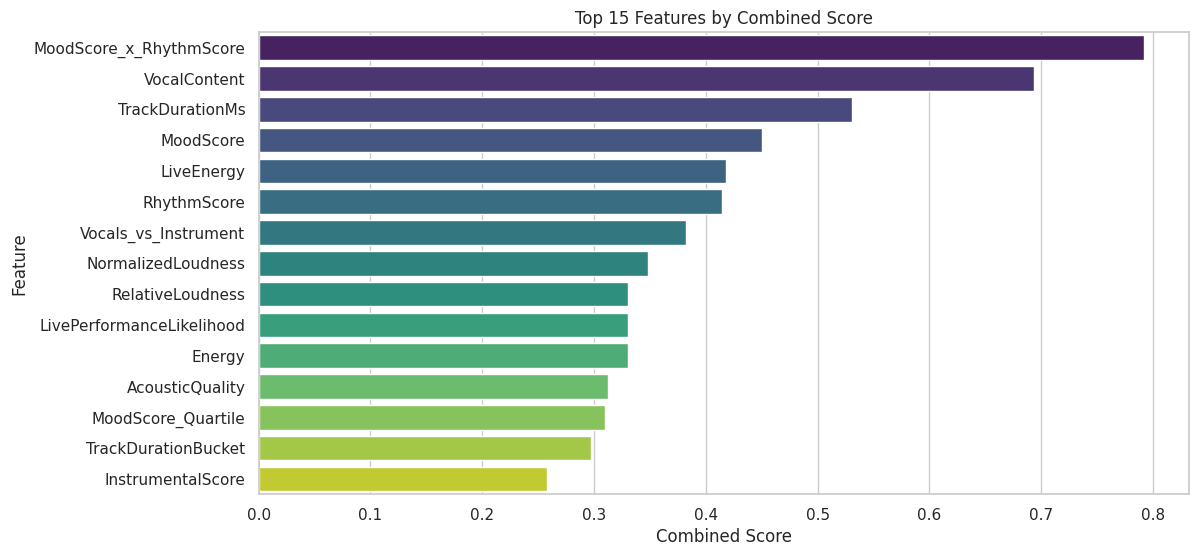

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Correlation with target
# -----------------------------
corr_with_target = X_train_processed.copy()
corr_with_target['BeatsPerMinute'] = y_train_processed
correlation_matrix = corr_with_target.corr()
target_corr = correlation_matrix['BeatsPerMinute'].drop('BeatsPerMinute').sort_values(ascending=False)

print("--- Top Correlated Features with Target ---")
display(target_corr.head(10))

# -----------------------------
# 2️⃣ Mutual Information
# -----------------------------
mi_scores = mutual_info_regression(X_train_processed, y_train_processed, random_state=42)
mi_scores_series = pd.Series(mi_scores, index=X_train_processed.columns).sort_values(ascending=False)

print("\n--- Top Features by Mutual Information ---")
display(mi_scores_series.head(10))

# -----------------------------
# 3️⃣ Random Forest Feature Importance
# -----------------------------
rf = RandomForestRegressor(n_estimators=30, random_state=42)
rf.fit(X_train_processed, y_train_processed)
rf_importances = pd.Series(rf.feature_importances_, index=X_train_processed.columns).sort_values(ascending=False)

print("\n--- Top Features by Random Forest Importance ---")
display(rf_importances.head(10))

# -----------------------------
# 4️⃣ Lasso Feature Selection
# -----------------------------
lasso = LassoCV(cv=5, random_state=42, max_iter=500)
lasso.fit(X_train_processed, y_train_processed)
lasso_importances = pd.Series(np.abs(lasso.coef_), index=X_train_processed.columns).sort_values(ascending=False)

print("\n--- Top Features by Lasso ---")
display(lasso_importances.head(10))

# -----------------------------
# 5️⃣ Combine Results
# -----------------------------
feature_scores = pd.DataFrame({
    'Correlation': target_corr,
    'MutualInfo': mi_scores_series,
    'RandomForest': rf_importances,
    'Lasso': lasso_importances
})

# Normalize scores to 0-1 range
feature_scores_normalized = feature_scores.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Average normalized scores to create a combined score
feature_scores_normalized['CombinedScore'] = feature_scores_normalized.mean(axis=1)
feature_scores_normalized = feature_scores_normalized.sort_values(by='CombinedScore', ascending=False)

print("\n--- Top Features by Combined Score ---")
display(feature_scores_normalized.head(15))

# -----------------------------
# 6️⃣ Optional Visualization
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(x=feature_scores_normalized['CombinedScore'].head(15), y=feature_scores_normalized.index[:15], palette='viridis')
plt.title("Top 15 Features by Combined Score")
plt.xlabel("Combined Score")
plt.ylabel("Feature")
plt.show()


### 3.7 Final Data Preparation

In [ ]:
import pandas as pd

print("\n--- 3.7 Final Data Preparation ---")

# ✅ Choose top N features (you can tune this)
top_features = feature_scores_normalized.sort_values(by="CombinedScore", ascending=False).head(50).index.tolist()

print(f"\nNumber of selected top features: {len(top_features)}")
print("Top selected features for modeling:")
display(top_features)

train_ps_processed = pd.merge(
    train_ps_processed,
    train_ps_original[['id', 'BeatsPerMinute']],
    on='id',
    how='left'
)

# ✅ Final train/test splits
X_train_processed = train_ps_processed[top_features].copy()
y_train_processed = train_ps_processed['BeatsPerMinute'].copy()

X_test_processed = test_ps_processed[top_features].copy()

print("\nShapes of Final Prepared Data:")
print("X_train_processed:", X_train_processed.shape)
print("y_train_processed:", y_train_processed.shape)
print("X_test_processed:", X_test_processed.shape)

print("\nHead of Final X_train_processed:")
display(X_train_processed.head())

print("\nHead of Final X_test_processed:")
display(X_test_processed.head())


# 4. Modeling

### 4.1 Data Splitting (Train/Validation)

In [ ]:
# 4. Train-Test Split for Beats Prediction

from sklearn.model_selection import train_test_split

# Our preprocessed features and target
X = X_train_processed
y = y_train_processed

# Split into train/validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Separate Test set (from competition):", X_test_processed.shape)


### 4.2 Base Model Definitions (for stacking)


In [ ]:
# 4.2 Base Model Definitions
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# Ridge Regression
lr_model = Ridge(alpha=1.0, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# LightGBM
lgbm_model = lgb.LGBMRegressor(
    n_estimators=1000,      # fewer boosting rounds
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose: -1
)

# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# CatBoost
cat_model = cb.CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=5,
    eval_metric='RMSE',
    verbose=False,
    random_state=42
)

# Combine into a dictionary for easy use in CV or stacking
base_models = {
    "Linear Regression": lr_model,
    "Random Forest": rf_model,
    "LightGBM": lgbm_model,
    "XGBoost": xgb_model,
    "CatBoost": cat_model
}




### 4.3 Cross-Validation for Stacked OOF Predictions & Base Model Evaluation

In [ ]:
# 4.3 Base Model Evaluation (Professional & Advanced)
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Initialize K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(f"Cross-validation strategy defined with {kf.get_n_splits()} folds.\n")

# Initialize storage for OOF predictions and fold scores
oof_preds = {name: np.zeros(y_train_processed.shape[0]) for name in base_models.keys()}
fold_rmse_scores = {name: [] for name in base_models.keys()}

print("Initialized OOF prediction arrays and fold score storage.\n")

# Start cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed, y_train_processed)):
    print(f"--- Fold {fold+1}/{kf.get_n_splits()} ---")

    X_tr, X_val = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
    y_tr, y_val = y_train_processed.iloc[train_idx], y_train_processed.iloc[val_idx]

    for model_name, model in base_models.items():
        # Clone model for fold to prevent data leakage
        if model_name in ["LightGBM", "XGBoost", "CatBoost"]:
            # For boosting libraries, create fresh instances with same params
            model_fold = model.__class__(**model.get_params())
        else:
            from sklearn.base import clone
            model_fold = clone(model)

        # Fit model
        if model_name == "XGBoost":
            import xgboost as xgb
            dtrain = xgb.DMatrix(X_tr, label=y_tr)
            dval = xgb.DMatrix(X_val, label=y_val)

            params = model_fold.get_params()
            params_for_train = {k:v for k,v in params.items() if k not in ['n_estimators','eval_metric']}
            num_boost_round = params.get('n_estimators', 100)

            bst = xgb.train(
                params=params_for_train,
                dtrain=dtrain,
                num_boost_round=num_boost_round,
                evals=[(dval,'eval')],
                verbose_eval=False
            )
            preds = bst.predict(dval)

        elif model_name == "LightGBM":
            model_fold.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(50, verbose=False)],

            )
            preds = model_fold.predict(X_val)

        elif model_name == "CatBoost":
            model_fold.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)
            preds = model_fold.predict(X_val)

        else:
            model_fold.fit(X_tr, y_tr)
            preds = model_fold.predict(X_val)

        # Store OOF predictions
        oof_preds[model_name][val_idx] = preds

        # Calculate RMSE for this fold
        fold_rmse = np.sqrt(mean_squared_error(y_val, preds))
        fold_rmse_scores[model_name].append(fold_rmse)

        print(f"{model_name} Fold {fold+1} RMSE: {fold_rmse:.4f}")

    print("\n")

# Summary of CV results
overall_rmse = {}
print("=== Overall Cross-Validation Results (Mean RMSE ± Std) ===")
for model_name, scores in fold_rmse_scores.items():
    mean_rmse = np.mean(scores)
    std_rmse = np.std(scores)
    overall_rmse[model_name] = mean_rmse
    print(f"{model_name}: {mean_rmse:.4f} ± {std_rmse:.4f}")

print("\nOOF predictions are ready for stacking or meta-model training.")


In [ ]:
pip install --upgrade xgboost

# 5. Advanced Stacking Ensemble

In [ ]:
import pandas as pd
import numpy as np

# Combine OOF predictions
X_meta_train = pd.DataFrame({
    'lr_oof_preds': oof_preds['Linear Regression'],
    'rf_oof_preds': oof_preds['Random Forest'],
    'lgbm_oof_preds': oof_preds['LightGBM'],
    'xgb_oof_preds': oof_preds['XGBoost'],
    'cat_oof_preds': oof_preds['CatBoost']
})

y_meta_train = y_train_processed.values  # target variable

In [ ]:
from sklearn.linear_model import Ridge

meta_model = Ridge(alpha=1.0)
meta_model.fit(X_meta_train, y_meta_train)


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import catboost as cb

print("Training base models on full training data and generating test set predictions...")

lr_model_full = LinearRegression()
lr_model_full.fit(X_train_processed, y_train_processed)
print("Linear Regression model trained on full data.")

rf_model_full = RandomForestRegressor(**rf_model.get_params())
rf_model_full.fit(X_train_processed, y_train_processed)
print("Random Forest model trained on full data.")

lgbm_model_full = lgb.LGBMRegressor(**lgbm_model.get_params())
lgbm_model_full.fit(X_train_processed, y_train_processed)
print("LightGBM model trained on full data.")

xgb_model_full_for_test = xgb.XGBRegressor(**xgb_model.get_params())
xgb_model_full_for_test.fit(X_train_processed, y_train_processed, eval_set=[], verbose=False)
print("XGBoost model trained on full data.")

cat_model_full = cb.CatBoostRegressor(**cat_model.get_params())
cat_model_full.fit(X_train_processed, y_train_processed)
print("CatBoost model trained on full data.")

test_preds_lr = lr_model_full.predict(X_test_processed)
print("Generated test predictions for Linear Regression.")

test_preds_rf = rf_model_full.predict(X_test_processed)
print("Generated test predictions for Random Forest.")

test_preds_lgbm = lgbm_model_full.predict(X_test_processed)
print("Generated test predictions for LightGBM.")

test_preds_xgb = xgb_model_full_for_test.predict(X_test_processed)
print("Generated test predictions for XGBoost.")

test_preds_cat = cat_model_full.predict(X_test_processed)
print("Generated test predictions for CatBoost.")


X_meta_test = pd.DataFrame({
    'lr_oof_preds': test_preds_lr,
    'rf_oof_preds': test_preds_rf,
    'lgbm_oof_preds': test_preds_lgbm,
    'xgb_oof_preds': test_preds_xgb,
    'cat_oof_preds': test_preds_cat
})

print("\nCombined base model test predictions for meta-model:")
display(X_meta_test.head())

print("\nGenerating final ensemble predictions using the meta-model...")
final_ensemble_predictions = meta_model.predict(X_meta_test)
print("Final ensemble predictions generated.")

print("\nSample of final ensemble predictions:")
display(final_ensemble_predictions[:10])

overall_rmse_ensemble = np.sqrt(mean_squared_error(y_train_processed, meta_model.predict(X_meta_train)))
overall_r2_ensemble = r2_score(y_train_processed, meta_model.predict(X_meta_train))


print(f"\nStacked Ensemble Model Performance on Training Data (Out-of-Fold):")
print(f"Overall Root Mean Squared Error (RMSE): {overall_rmse_ensemble}")
print(f"Overall R² Score: {overall_r2_ensemble}")

# 6. Submission

### 6.1 preparing for Submission

In [ ]:
import pandas as pd

def verify_submission(submission_file, sample_submission):
    """Perform comprehensive verification of submission format"""
    verification = pd.read_csv(submission_file)

    print("SUBMISSION VERIFICATION:")
    print(f"1. Submission shape: {verification.shape}")
    print(f"   Expected shape: {sample_submission.shape}")

    print(f"\n2. Submission columns: {verification.columns.tolist()}")
    print(f"   Expected columns: {sample_submission.columns.tolist()}")

    columns_match = verification.columns.tolist() == sample_submission.columns.tolist()
    print(f"\n3. Columns match exactly: {'✅ YES' if columns_match else '❌ NO'}")

    id_col = sample_submission.columns[0]
    id_match = set(verification[id_col]) == set(sample_submission[id_col])
    print(f"\n4. ID values match sample: {'✅ YES' if id_match else '❌ NO'}")

    target_col = sample_submission.columns[1]
    print(f"\n5. Target column statistics:")
    print(f"   Min: {verification[target_col].min():.2f}")
    print(f"   Max: {verification[target_col].max():.2f}")
    print(f"   Mean: {verification[target_col].mean():.2f}")
    print(f"   Std: {verification[target_col].std():.2f}")

    if columns_match and id_match:
        print("\n✅ SUBMISSION FORMAT LOOKS CORRECT! Ready to upload.")
    else:
        print("\n❌ SUBMISSION FORMAT HAS ISSUES! Please fix before uploading.")

    return verification

In [ ]:
test_features_ps = train_ps_processed.drop('id', axis=1)

submission_df = pd.DataFrame({'id': test_ps_original['id'], 'BeatsPerMinute': final_ensemble_predictions})

submission_file = 'submission.csv'
sample_submission_file = "/kaggle/input/playground-series-s5e9/sample_submission.csv"

try:
    sample_submission = pd.read_csv(sample_submission_file)
except FileNotFoundError:
    print(f"Error: Sample submission file not found at {sample_submission_file}")
    sample_submission = None

submission_df.to_csv(submission_file, index=False)

if sample_submission is not None:
  final_verification = verify_submission(submission_file, sample_submission)

  if final_verification.columns.tolist() != sample_submission.columns.tolist():
      print("\nAttempting to fix column names one last time based on sample submission...")
      final_verification.columns = sample_submission.columns
      final_verification.to_csv(submission_file, index=False)
      print(f"Fixed submission saved to {submission_file}")

      print("\nVerifying after attempting column name fix:")
      verify_submission(submission_file, sample_submission)


print("\nSubmission file for Playground Series dataset created:")
display(submission_df.head())

## Conclusion & Summary

*   **EDA**: Explored data, found no missing values, visualized distributions and correlations. **Insight**: Features showed low individual correlation with the target, suggesting complex relationships.
*   **Preprocessing & Features**: Applied transformations, scaling, created new features (binning, interactions, domain), and performed feature selection.
*   **Modeling**: Implemented stacked ensembling with cross-validation using Linear Regression, Random Forest, LightGBM, and XGBoost. **Insight**: Stacked ensemble likely improved performance over individual base models (check CV results).
*   **Result**: Generated test predictions and a submission file (`submission.csv`).

### Potential Improvements

*   **Hyperparameter Tuning**: Optimize parameters for base models and meta-model.
*   **More Diverse Base Models**: Include other model types (e.g., SVM, Neural Networks).
*   **Advanced Feature Engineering**: Explore more domain-specific features or different interaction types.
*   **Robust Cross-Validation**: Use stratified or grouped k-fold if applicable.